In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")

print("Path to dataset files:", path)

shipsnet_path = path + r"\\shipsnet.json"

Path to dataset files: C:\Users\wwden\.cache\kagglehub\datasets\rhammell\ships-in-satellite-imagery\versions\9


In [2]:
import json

with open(shipsnet_path) as f:
    data = json.load(f)  # NOT json.dumps()

def print_structure(d, indent=0):
    prefix = '  ' * indent
    if isinstance(d, dict):
        for k, v in d.items():
            print(f"{prefix}{k}: {type(v).__name__}")
            print_structure(v, indent + 1)
    elif isinstance(d, list):
        print(f"{prefix}list[{len(d)}]: {type(d[0]).__name__}" if d else f"{prefix}list: empty")
        if d:
            print_structure(d[0], indent + 1)

print_structure(data)

data: list
  list[4000]: list
    list[19200]: int
labels: list
  list[4000]: int
locations: list
  list[4000]: list
    list[2]: float
scene_ids: list
  list[4000]: str


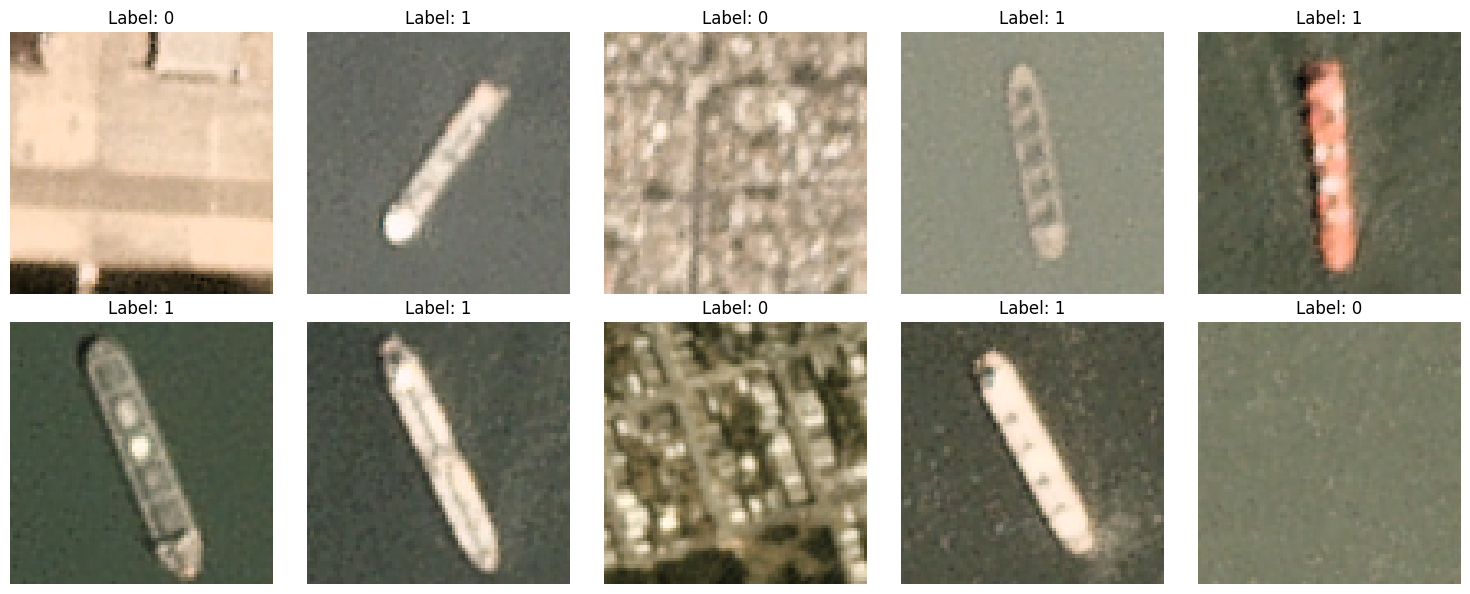

In [3]:
import numpy as np
import matplotlib.pyplot as plt

X_data = np.array(data["data"][:2000])
y_data = np.array(data["labels"][:2000])

X_data_transformed = X_data.reshape(-1, 3, 80, 80).transpose(0, 2, 3, 1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
indices = np.random.randint(0,2000,size = 10)

for ax, idx in zip(axes.flat, indices):
    ax.imshow(X_data_transformed[idx].astype(np.uint8))
    ax.set_title(f"Label: {y_data[idx]}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
import os
import sys

# Save current working directory
cwd = os.getcwd()

# Change to parent directory
parent_dir = os.path.abspath(os.path.join(cwd, '..'))
os.chdir(parent_dir)

# Temporarily add parent directory to sys.path
sys.path.insert(0, parent_dir)
import framework
sys.path.pop(0)

# Return to original directory
os.chdir(cwd)


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from CNN import CNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

X_tensor = torch.tensor(X_data_transformed, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y_data, dtype=torch.long)

# Split indices
num_samples = X_tensor.size(0)
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size

indices = torch.randperm(num_samples)
train_idx, test_idx = indices[:train_size], indices[train_size:]

# Create splits
X_train, y_train = X_tensor[train_idx], y_tensor[train_idx]
X_test, y_test = X_tensor[test_idx], y_tensor[test_idx]

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CNN(F.relu, dropout_rate=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

best_loss = float('inf')

for epoch in range(1000):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = 100 * total_correct / total_samples

    print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    if avg_loss > best_loss * 2:
        print("Stopping early due to loss increase")
        break

    best_loss = avg_loss

# Test evaluation
model.eval()
test_correct = 0
test_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_samples += labels.size(0)

test_accuracy = 100 * test_correct / test_samples
print(f"Test Accuracy: {test_accuracy:.2f}%")

cuda
Epoch 1 completed, Avg Loss: 1.0144, Accuracy: 76.31%
Epoch 2 completed, Avg Loss: 0.2096, Accuracy: 92.38%
Epoch 3 completed, Avg Loss: 0.1368, Accuracy: 95.31%
Epoch 4 completed, Avg Loss: 0.1068, Accuracy: 96.62%
Epoch 5 completed, Avg Loss: 0.0875, Accuracy: 97.31%
Epoch 6 completed, Avg Loss: 0.0983, Accuracy: 97.12%
Epoch 7 completed, Avg Loss: 0.0893, Accuracy: 97.44%
Epoch 8 completed, Avg Loss: 0.0751, Accuracy: 97.94%
Epoch 9 completed, Avg Loss: 0.0698, Accuracy: 97.88%
Epoch 10 completed, Avg Loss: 0.0491, Accuracy: 98.56%
Epoch 11 completed, Avg Loss: 0.0615, Accuracy: 97.69%
Epoch 12 completed, Avg Loss: 0.0638, Accuracy: 98.25%
Epoch 13 completed, Avg Loss: 0.0473, Accuracy: 98.62%
Epoch 14 completed, Avg Loss: 0.0395, Accuracy: 98.56%
Epoch 15 completed, Avg Loss: 0.0440, Accuracy: 99.00%
Epoch 16 completed, Avg Loss: 0.0323, Accuracy: 99.06%
Epoch 17 completed, Avg Loss: 0.0336, Accuracy: 98.88%
Epoch 18 completed, Avg Loss: 0.0417, Accuracy: 98.69%
Epoch 19 compl

In [6]:
from framework.attack import Injector
from framework.criterion import multiclass_classification_accuracy

pred = model(X_test.to(device))

baseline = multiclass_classification_accuracy(y_test.cpu().detach().numpy(), pred.cpu().detach().numpy())
baseline

0.9925

In [7]:
crit = lambda a,b : multiclass_classification_accuracy(a.cpu().detach().numpy(), b.cpu().detach().numpy())

inj = Injector(model, X_test, y_test, crit, "cuda")

import pandas as pd
df = pd.DataFrame()
for bit in [0,1,3,6,10,15,21]:
    print(bit)

    results = inj.run_stochastic_seu(bit,0.5)

    res = pd.DataFrame(results)
    res["bit_i"] = bit
    df = pd.concat([df, res])

df

Testing a forward pass on cuda...
Basline Criterion Score: 0.9925
0
1
3
6
10
15
21


,tensor_location,criterion_score,layer_name,value_before,value_after,bit_i
0,"(0, 0, 0, 1)",0.9925,conv1.weight,-0.172856,0.172856,0
1,"(0, 0, 0, 2)",0.9950,conv1.weight,-0.126651,0.126651,0
2,"(0, 0, 1, 1)",0.9825,conv1.weight,-0.131081,0.131081,0
3,"(0, 0, 1, 2)",0.9925,conv1.weight,-0.076107,0.076107,0
4,"(0, 0, 2, 0)",0.9850,conv1.weight,-0.145962,0.145962,0
...,...,...,...,...,...,...
3812,"(1, 793)",0.9925,fc1.weight,0.013711,0.013711,21
3813,"(1, 795)",0.9925,fc1.weight,0.009098,0.009097,21
3814,"(1, 796)",0.9925,fc1.weight,-0.010726,-0.010727,21
3815,"(1, 797)",0.9925,fc1.weight,0.016965,0.016967,21


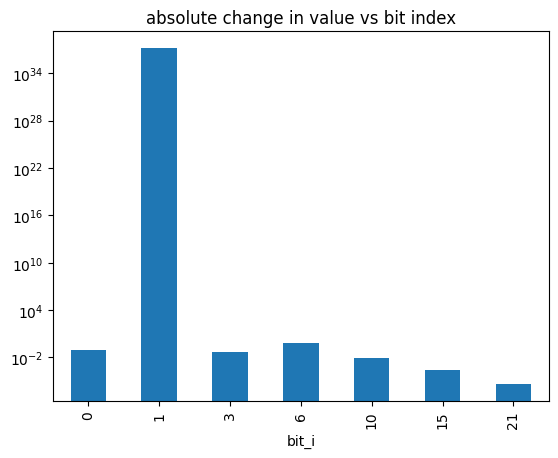

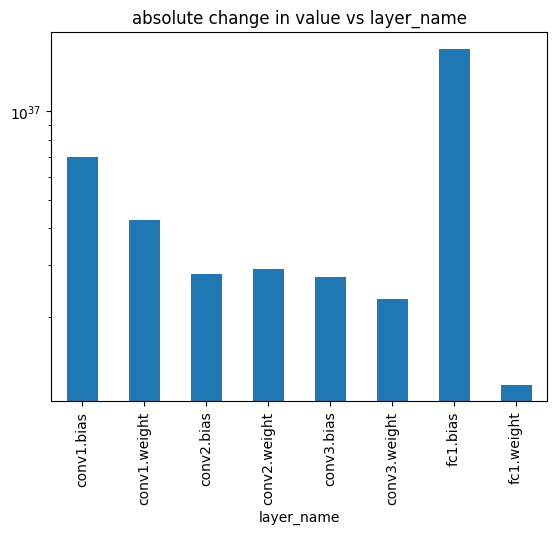

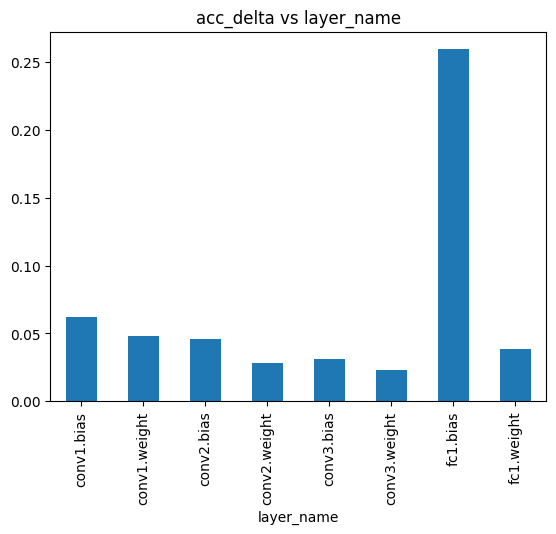

In [8]:
df["value_delta"] = abs(df["value_before"] - df["value_after"])
df["acc_delta"] = baseline - df["criterion_score"]
df.describe()

df.groupby("bit_i")["value_delta"].mean().plot(kind = "bar", title = "absolute change in value vs bit index")
plt.yscale("log")
plt.show()

df.groupby("layer_name")["value_delta"].mean().plot(kind = "bar", title = "absolute change in value vs layer_name")
plt.yscale("log")
plt.show()

df.groupby("layer_name")["acc_delta"].mean().plot(kind = "bar", title = "acc_delta vs layer_name")
plt.show()